In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 64
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

In [3]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, classification_report

import math

import matplotlib.pyplot as plt

In [4]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [6]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

def labels_1d_to_2d(labels_1d):
    labels_2d = np.eye(2)[labels_1d]
    return labels_2d

# Model

In [8]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 50, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 370, ## Dense layer parameters
#                  prob = 0.75, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, 
#                                 strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
#                       loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
#                       loss = loss)

#     return model

In [9]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 10, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 25, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 10,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 128, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu'
                             )(x4)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [10]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 25, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 150, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0005, 
#                  loss = 'binary_crossentropy', metrics = None):
    
#     beta = 0.001
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta),
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

#     return model

In [11]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 50)       5300        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 50)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 20, 50)       0           ['activation[0][0]']             
                                                                                              

# Read Data

In [12]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Independent Dataset

In [13]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Exploratory Data Analysis

In [14]:
# empty char count per sequence
train_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in train_data['Sequence']]
# incomplete sequence flag
train_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in train_data['Sequence']]

indpe_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in indpe_data['Sequence']]
indpe_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in indpe_data['Sequence']]

In [15]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

### Train

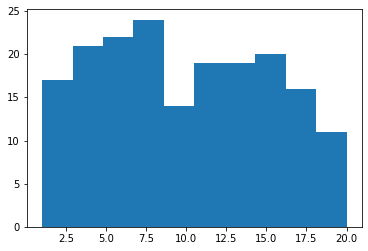

Total empty records: 183
Ratio empty/total: 0.07682619647355164


In [16]:
plt.hist(train_data['Empty_count'][train_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(train_data['has_empty']))
print('Ratio empty/total:', sum(train_data['has_empty'])/train_data.shape[0])

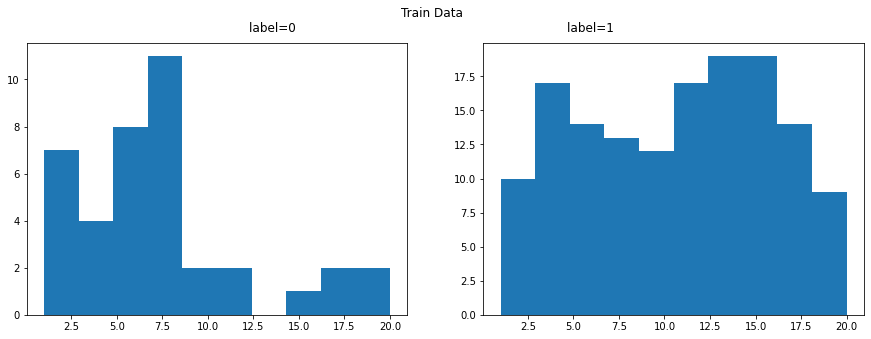

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == -1)])
axs[1].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == 1)])
plt.show()

In [18]:
train_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,39
1,1,144


### independent

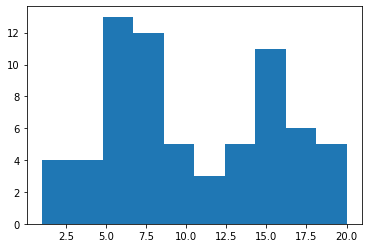

Total empty records: 68
Ratio empty/total: 0.05551020408163265


In [19]:
plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(indpe_data['has_empty']))
print('Ratio empty/total:', sum(indpe_data['has_empty'])/indpe_data.shape[0])

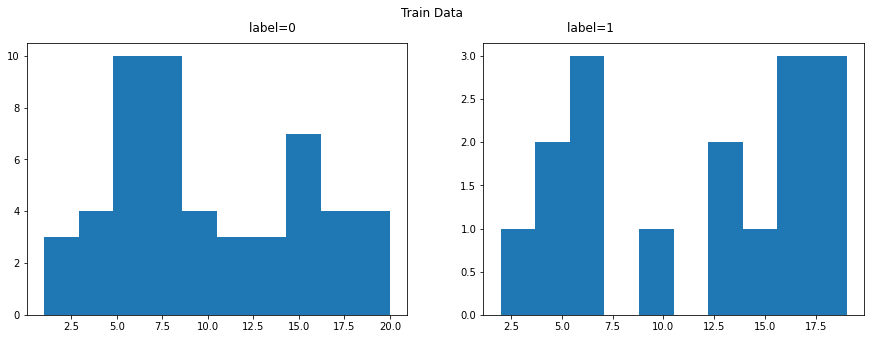

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == -1)])
axs[1].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == 1)])
plt.show()

In [21]:
indpe_data.groupby(["label_original"]).sum().filter(['has_empty'])

,has_empty
label_original,
-1,52
1,16


In [22]:
_,_ = print_and_get_stats(train_data, indpe_data)

Current train_label_nonempty_ratio: 0.2708333333333333 train_label_ratio: 1.0
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


In [23]:
# EDA - get drop lengths from distribution

# from __future__ import division
# import numpy as np
# import matplotlib.pyplot as plt

# hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=10)

# bin_midpoints = bins[:-1] + np.diff(bins)/2
# cdf = np.cumsum(hist)
# cdf = cdf / cdf[-1]
# values = np.random.rand(100)
# value_bins = np.searchsorted(cdf, values)
# random_from_cdf = bin_midpoints[value_bins]

# plt.subplot(121)
# plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], 10)
# plt.subplot(122)
# plt.hist(np.round(random_from_cdf).astype(int), 10)
# plt.show()

# Data Augmentation on Training dataset

In [24]:
import random

def sequence_truncate(seq, random_length):
    rep_str = "".join(['-']*random_length)
    if np.random.choice((True, False)):
        return_seq = rep_str + seq[random_length:]
    else:
        return_seq = seq[:-random_length] + rep_str
    return return_seq

def random_sequence_truncate(seq):
    random_length = np.random.randint(1, 20)
    return_seq = sequence_truncate(seq, random_length)
    return return_seq

def repeat_truncate_sequence_steps(seq, factor):
    random_length = random.sample(range(1, int(len(seq)/2)), 
                                  factor)
    return_seqs = []
    for i in range(factor):
        ret_seq = sequence_truncate(seq, random_length[i])
        return_seqs.append(ret_seq)
    return return_seqs

def truncate_sequence_by_len(seq, ran_len):
    return_seqs = []
    ret_seq = sequence_truncate(seq, ran_len)
    return ret_seq

In [25]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

In [26]:
def augmentation(data, indpe_data, aug_factor=0.25, neg_pos_factor=1):
    # empty char count per sequence
    data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in data['Sequence']]
    # incomplete sequence flag
    data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in data['Sequence']]
    
    neg_data = data[data['label_original'] == -1].reset_index(drop=True)
    pos_data = data[data['label_original'] == 1].reset_index(drop=True)
    # neg_data = data.reset_index(drop=True)

    not_empty_neg_idxs = np.where(neg_data['has_empty'] != True)[0]
    not_empty_neg_idxs = np.random.permutation(not_empty_neg_idxs)[0:int(not_empty_neg_idxs.shape[0]*aug_factor)]
    not_empty_pos_idxs = np.where(pos_data['has_empty'] != True)[0]
    not_empty_pos_idxs = np.random.permutation(not_empty_pos_idxs)[0:int(not_empty_neg_idxs.shape[0]/neg_pos_factor)]

    ##### Getting missing distribution
    hist, bins = np.histogram(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0], bins=20)
    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    ##### Negative records augmentation
    neg_values = np.random.rand(not_empty_neg_idxs.shape[0])
    neg_value_bins = np.searchsorted(cdf, neg_values)
    neg_random_from_cdf = bin_midpoints[neg_value_bins]
    neg_random_from_cdf = np.round(neg_random_from_cdf).astype(int)

    for idx, ran_len in zip(list(not_empty_neg_idxs), list(list(neg_random_from_cdf))):
        record = neg_data.iloc[idx].to_dict()
        seq = truncate_sequence_by_len(record['Sequence'], ran_len)
        record['Sequence'] = seq
        neg_data = neg_data.append(record, ignore_index=True)

    ##### Positive records augmentation
    pos_values = np.random.rand(not_empty_pos_idxs.shape[0])
    pos_value_bins = np.searchsorted(cdf, pos_values)
    pos_random_from_cdf = bin_midpoints[pos_value_bins]
    pos_random_from_cdf = np.round(pos_random_from_cdf).astype(int)

    for idx, ran_len in zip(list(not_empty_pos_idxs), list(list(pos_random_from_cdf))):
        record = pos_data.iloc[idx].to_dict()
        seq = truncate_sequence_by_len(record['Sequence'], ran_len)
        record['Sequence'] = seq
        pos_data = pos_data.append(record, ignore_index=True)

    final_data = pd.concat((neg_data, pos_data, data), ignore_index=True)

    final_data = final_data.drop_duplicates().reset_index(drop=True)
    
    return final_data

In [27]:
## Build the K-fold from dataset
def build_kfold_df(data_df, k=10, shuffle=False, seed=None):
    data_df = data_df.reset_index(drop=True)
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(data_df['label_original'], data_df['label_original']):
        X_train = data_df.iloc[train_index].reset_index(drop=True)
        X_test = data_df.iloc[test_index].reset_index(drop=True)
        kfoldList.append({
            "train": X_train,
            "test": X_test
        })
    return kfoldList

In [28]:
def build_folds_from_kfold_df(input_folds_in_df, indpe_data, all_char_dict):
    folds = []
    for fold in input_folds_in_df:
        
        fold_train_data = fold['train'].reset_index(drop=True)
        fold_test_data = fold['test'].reset_index(drop=True)
        
        fold_train_data_aug = augmentation(fold_train_data, indpe_data).reset_index(drop=True)
        
        ##################################################################################
        ##### Train data
        ##################################################################################
        
        # Create OHE of sequence
        fold_train_data_aug['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                                         for val in fold_train_data_aug["Sequence"]])

        # Fix the labels
        fold_train_data_aug['label'] = pd.Series([1 if val == 1 else 0 
                                                  for val in fold_train_data_aug["label_original"]])

        # Extract features and labels
        train_features = np.array(list(fold_train_data_aug['OHE_Sequence']))
        train_labels = np.array(list(fold_train_data_aug['label']))
        train_labels = train_labels.reshape((train_labels.shape[0], 1))
        
        ##################################################################################
        ##### Test data
        ##################################################################################
        
        # Create OHE of sequence
        fold_test_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                                    for val in fold_test_data["Sequence"]])
        
        # Fix the labels
        fold_test_data['label'] = pd.Series([1 if val == 1 else 0 
                                             for val in fold_test_data["label_original"]])

        # Extract features and labels
        test_features = np.array(list(fold_test_data['OHE_Sequence']))
        test_labels = np.array(list(fold_test_data['label']))
        test_labels = test_labels.reshape((test_labels.shape[0], 1))
        
        folds.append(
            {
                'X_train':train_features,
                'X_test':test_features,
                'y_train':train_labels,
                'y_test':test_labels
            }
        )
        
    return folds

In [29]:
final_data = augmentation(train_data, indpe_data)

In [30]:
# empty char count per sequence
final_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in final_data['Sequence']]
# incomplete sequence flag
final_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in final_data['Sequence']]

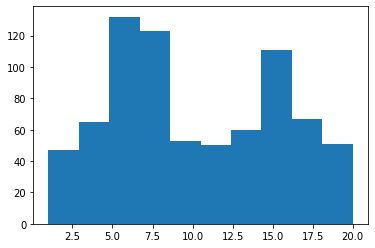

Total empty records: 759
Ratio empty/total: 0.2565922920892495


In [31]:
plt.hist(final_data['Empty_count'][final_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(final_data['has_empty']))
print('Ratio empty/total:', sum(final_data['has_empty'])/final_data.shape[0])

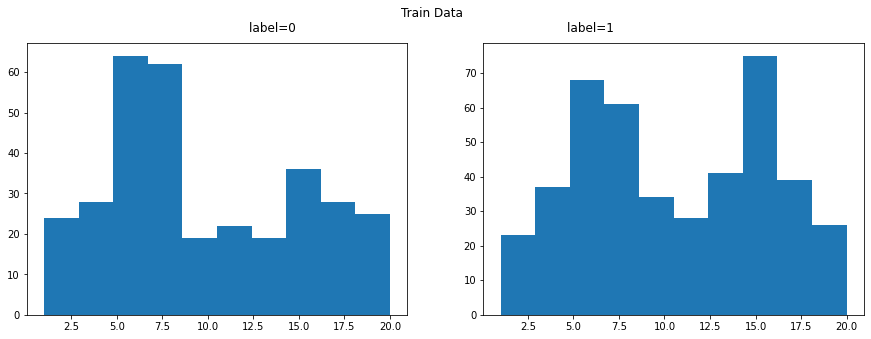

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(final_data['Empty_count'][(final_data['Empty_count'] != 0) & (final_data['label_original'] == -1)])
axs[1].hist(final_data['Empty_count'][(final_data['Empty_count'] != 0) & (final_data['label_original'] == 1)])
plt.show()

In [33]:
final_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,327
1,1,432


##  Final preparations for full augmented training data & k-fold training data

In [34]:
##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i

##################################################################################
##### Generate k-fold training data
##################################################################################    

folds_df = build_kfold_df(train_data, k=n_fold)
folds = build_folds_from_kfold_df(folds_df, 
                                  indpe_data, 
                                  all_char_dict)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

##################################################################################
##### Create OHE of sequence
##################################################################################

train_data = augmentation(train_data, indpe_data)

train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

train_features = np.array(list(train_data['OHE_Sequence']))
train_labels = np.array(list(train_data['label']))
train_labels = train_labels.reshape((train_labels.shape[0], 1))

input_seq_shape = train_features[0].shape

# Final prep for Independent dataset

In [35]:
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

In [36]:
for fold in folds:
    print(fold['X_train'].shape, fold['y_train'].shape, fold['X_test'].shape, fold['y_test'].shape)

(2365, 41, 21) (2365, 1) (477, 41, 21) (477, 1)
(2365, 41, 21) (2365, 1) (477, 41, 21) (477, 1)
(2366, 41, 21) (2366, 1) (476, 41, 21) (476, 1)
(2364, 41, 21) (2364, 1) (476, 41, 21) (476, 1)
(2366, 41, 21) (2366, 1) (476, 41, 21) (476, 1)


# Training

In [101]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
              callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    del model
    tf.keras.backend.clear_session()
    


Train/Test model on Fold #0.
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.9794
Epoch 1: val_loss improved from inf to 0.94786, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold0.hdf5
37/37 [==============================] - 3s 25ms/step - loss: 0.9794 - val_loss: 0.9479
Epoch 2/100
33/37 [=========================>....] - ETA: 0s - loss: 0.9413
Epoch 2: val_loss improved from 0.94786 to 0.92372, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold0.hdf5
37/37 [==============================] - 0s 11ms/step - loss: 0.9405 - val_loss: 0.9237
Epoch 3/100
33/37 [=========================>....] - ETA: 0s - loss: 0.9167
Epoch 3: val_loss improved from 0.92372 to 0.89837, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold0.hdf5


34/37 [==========================>...] - ETA: 0s - loss: 0.3679
Epoch 32: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 10ms/step - loss: 0.3721 - val_loss: 0.8276
Epoch 33/100
37/37 [==============================] - ETA: 0s - loss: 0.3655
Epoch 33: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 10ms/step - loss: 0.3655 - val_loss: 0.8023
Epoch 34/100
35/37 [===========================>..] - ETA: 0s - loss: 0.3791
Epoch 34: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 9ms/step - loss: 0.3749 - val_loss: 0.8501
Epoch 35/100
35/37 [===========================>..] - ETA: 0s - loss: 0.3393
Epoch 35: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 9ms/step - loss: 0.3396 - val_loss: 0.8156
Epoch 36/100
37/37 [==============================] - ETA: 0s - loss: 0.3482
Epoch 36: val_loss did not improve from 0.75504
37/37 [==============================]

37/37 [==============================] - 0s 10ms/step - loss: 0.2159 - val_loss: 0.9381
Epoch 71/100
36/37 [============================>.] - ETA: 0s - loss: 0.2176
Epoch 71: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 9ms/step - loss: 0.2184 - val_loss: 1.0674
Epoch 72/100
31/37 [========================>.....] - ETA: 0s - loss: 0.2178
Epoch 72: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 10ms/step - loss: 0.2198 - val_loss: 0.9368
Epoch 73/100
36/37 [============================>.] - ETA: 0s - loss: 0.2140
Epoch 73: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 11ms/step - loss: 0.2124 - val_loss: 1.0481
Epoch 74/100
37/37 [==============================] - ETA: 0s - loss: 0.2382
Epoch 74: val_loss did not improve from 0.75504
37/37 [==============================] - 0s 10ms/step - loss: 0.2382 - val_loss: 0.9732
Epoch 75/100
32/37 [========================>.....] - ETA: 0s

Epoch 6/100
33/37 [=========================>....] - ETA: 0s - loss: 0.8175
Epoch 6: val_loss improved from 0.83383 to 0.76843, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold1.hdf5
37/37 [==============================] - 0s 11ms/step - loss: 0.8180 - val_loss: 0.7684
Epoch 7/100
37/37 [==============================] - ETA: 0s - loss: 0.7758
Epoch 7: val_loss improved from 0.76843 to 0.71691, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold1.hdf5
37/37 [==============================] - 0s 12ms/step - loss: 0.7758 - val_loss: 0.7169
Epoch 8/100
37/37 [==============================] - ETA: 0s - loss: 0.7468
Epoch 8: val_loss improved from 0.71691 to 0.71043, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold1.hdf5
37/37 [===================

37/37 [==============================] - 0s 12ms/step - loss: 0.3627 - val_loss: 0.6977
Epoch 37/100
32/37 [========================>.....] - ETA: 0s - loss: 0.3585
Epoch 37: val_loss did not improve from 0.60654
37/37 [==============================] - 0s 10ms/step - loss: 0.3547 - val_loss: 0.6551
Epoch 38/100
36/37 [============================>.] - ETA: 0s - loss: 0.3275
Epoch 38: val_loss did not improve from 0.60654
37/37 [==============================] - 0s 11ms/step - loss: 0.3299 - val_loss: 0.6934
Epoch 39/100
32/37 [========================>.....] - ETA: 0s - loss: 0.3277
Epoch 39: val_loss did not improve from 0.60654
37/37 [==============================] - 0s 12ms/step - loss: 0.3274 - val_loss: 0.6885
Epoch 40/100
32/37 [========================>.....] - ETA: 0s - loss: 0.3341
Epoch 40: val_loss did not improve from 0.60654
37/37 [==============================] - 0s 10ms/step - loss: 0.3327 - val_loss: 0.7020
Epoch 41/100
37/37 [==============================] - ETA: 0

37/37 [==============================] - 0s 11ms/step - loss: 0.7296 - val_loss: 0.7452
Epoch 9/100
33/37 [=========================>....] - ETA: 0s - loss: 0.7016
Epoch 9: val_loss improved from 0.74517 to 0.73267, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold2.hdf5
37/37 [==============================] - 0s 11ms/step - loss: 0.6972 - val_loss: 0.7327
Epoch 10/100
36/37 [============================>.] - ETA: 0s - loss: 0.6835
Epoch 10: val_loss improved from 0.73267 to 0.72646, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold2.hdf5
37/37 [==============================] - 0s 11ms/step - loss: 0.6837 - val_loss: 0.7265
Epoch 11/100
36/37 [============================>.] - ETA: 0s - loss: 0.6678
Epoch 11: val_loss improved from 0.72646 to 0.71728, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_T

Epoch 40/100
37/37 [==============================] - ETA: 0s - loss: 0.3551
Epoch 40: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.3551 - val_loss: 0.7439
Epoch 41/100
33/37 [=========================>....] - ETA: 0s - loss: 0.3320
Epoch 41: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.3319 - val_loss: 0.7385
Epoch 42/100
33/37 [=========================>....] - ETA: 0s - loss: 0.3325
Epoch 42: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.3342 - val_loss: 0.7936
Epoch 43/100
34/37 [==========================>...] - ETA: 0s - loss: 0.3376
Epoch 43: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.3353 - val_loss: 0.7326
Epoch 44/100
32/37 [========================>.....] - ETA: 0s - loss: 0.3290
Epoch 44: val_loss did not improve from 0.67229
37/37 [================

37/37 [==============================] - 0s 9ms/step - loss: 0.2389 - val_loss: 0.8287
Epoch 79/100
34/37 [==========================>...] - ETA: 0s - loss: 0.2140
Epoch 79: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.2135 - val_loss: 0.8810
Epoch 80/100
31/37 [========================>.....] - ETA: 0s - loss: 0.2191
Epoch 80: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.2294 - val_loss: 0.8339
Epoch 81/100
34/37 [==========================>...] - ETA: 0s - loss: 0.2359
Epoch 81: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.2309 - val_loss: 0.8355
Epoch 82/100
33/37 [=========================>....] - ETA: 0s - loss: 0.2071
Epoch 82: val_loss did not improve from 0.67229
37/37 [==============================] - 0s 10ms/step - loss: 0.2056 - val_loss: 0.8793
Epoch 83/100
35/37 [===========================>..] - ETA: 0s

37/37 [==============================] - 0s 12ms/step - loss: 0.6978 - val_loss: 0.6174
Epoch 11/100
33/37 [=========================>....] - ETA: 0s - loss: 0.7055
Epoch 11: val_loss improved from 0.61739 to 0.60942, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold3.hdf5
37/37 [==============================] - 0s 12ms/step - loss: 0.6999 - val_loss: 0.6094
Epoch 12/100
35/37 [===========================>..] - ETA: 0s - loss: 0.6760
Epoch 12: val_loss improved from 0.60942 to 0.58600, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold3.hdf5
37/37 [==============================] - 0s 11ms/step - loss: 0.6744 - val_loss: 0.5860
Epoch 13/100
32/37 [========================>.....] - ETA: 0s - loss: 0.6635
Epoch 13: val_loss improved from 0.58600 to 0.58175, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2

Epoch 38/100
37/37 [==============================] - ETA: 0s - loss: 0.3737
Epoch 38: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 10ms/step - loss: 0.3737 - val_loss: 0.5216
Epoch 39/100
36/37 [============================>.] - ETA: 0s - loss: 0.3633
Epoch 39: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 9ms/step - loss: 0.3650 - val_loss: 0.4986
Epoch 40/100
34/37 [==========================>...] - ETA: 0s - loss: 0.3699
Epoch 40: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 10ms/step - loss: 0.3703 - val_loss: 0.5253
Epoch 41/100
32/37 [========================>.....] - ETA: 0s - loss: 0.3417
Epoch 41: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 10ms/step - loss: 0.3371 - val_loss: 0.5459
Epoch 42/100
34/37 [==========================>...] - ETA: 0s - loss: 0.3492
Epoch 42: val_loss did not improve from 0.49731
37/37 [=================

37/37 [==============================] - 0s 11ms/step - loss: 0.2455 - val_loss: 0.5785
Epoch 77/100
32/37 [========================>.....] - ETA: 0s - loss: 0.2207
Epoch 77: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 10ms/step - loss: 0.2237 - val_loss: 0.6458
Epoch 78/100
35/37 [===========================>..] - ETA: 0s - loss: 0.2446
Epoch 78: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 11ms/step - loss: 0.2435 - val_loss: 0.5835
Epoch 79/100
37/37 [==============================] - ETA: 0s - loss: 0.2344
Epoch 79: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 10ms/step - loss: 0.2344 - val_loss: 0.6146
Epoch 80/100
35/37 [===========================>..] - ETA: 0s - loss: 0.2043
Epoch 80: val_loss did not improve from 0.49731
37/37 [==============================] - 0s 9ms/step - loss: 0.2104 - val_loss: 0.6370
Epoch 81/100
33/37 [=========================>....] - ETA: 0s

Epoch 10/100
37/37 [==============================] - ETA: 0s - loss: 0.6755
Epoch 10: val_loss improved from 0.77558 to 0.75784, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold4.hdf5
37/37 [==============================] - 0s 12ms/step - loss: 0.6755 - val_loss: 0.7578
Epoch 11/100
34/37 [==========================>...] - ETA: 0s - loss: 0.6472
Epoch 11: val_loss did not improve from 0.75784
37/37 [==============================] - 0s 10ms/step - loss: 0.6472 - val_loss: 0.7618
Epoch 12/100
37/37 [==============================] - ETA: 0s - loss: 0.6472
Epoch 12: val_loss improved from 0.75784 to 0.74547, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\bestModel-fold4.hdf5
37/37 [==============================] - 0s 12ms/step - loss: 0.6472 - val_loss: 0.7455
Epoch 13/100
31/37 [========================>.....] - ETA: 0s - loss: 0.637

37/37 [==============================] - 0s 10ms/step - loss: 0.3267 - val_loss: 0.7726
Epoch 43/100
36/37 [============================>.] - ETA: 0s - loss: 0.3114
Epoch 43: val_loss did not improve from 0.70242
37/37 [==============================] - 0s 9ms/step - loss: 0.3130 - val_loss: 0.8084
Epoch 44/100
36/37 [============================>.] - ETA: 0s - loss: 0.3047
Epoch 44: val_loss did not improve from 0.70242
37/37 [==============================] - 0s 9ms/step - loss: 0.3043 - val_loss: 0.8114
Epoch 45/100
35/37 [===========================>..] - ETA: 0s - loss: 0.3105
Epoch 45: val_loss did not improve from 0.70242
37/37 [==============================] - 0s 9ms/step - loss: 0.3114 - val_loss: 0.8212
Epoch 46/100
36/37 [============================>.] - ETA: 0s - loss: 0.3033
Epoch 46: val_loss did not improve from 0.70242
37/37 [==============================] - 0s 9ms/step - loss: 0.3033 - val_loss: 0.7856
Epoch 47/100
34/37 [==========================>...] - ETA: 0s - 

## k-fold Training evaluation

In [102]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.729241,0.72766,0.807623,0.738051,0.720358,0.459661
Train,0.889400,0.88930,0.949517,0.889397,0.889403,0.779566


In [103]:

# Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Test	0.731321	0.727759	0.806616	0.745579	0.717011	0.463860
# Train	0.856681	0.845510	0.927639	0.873001	0.840358	0.714348

In [104]:
# 10, 5 - larger network

# Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Test	0.735525	0.740360	0.809042	0.728803	0.742189	0.472127
# Train	0.951550	0.963889	0.987920	0.938102	0.964995	0.903821

In [105]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.677149,0.664093,"[0.0, 0.0041841004184100415, 0.037656903765690...","[0.0, 0.0, 0.0, 0.004201680672268907, 0.004201...","[1.9778378, 0.97783774, 0.95496964, 0.95408726...",0.747020,0.719665,0.634454,0.355434
3,1,Test,0.729560,0.751152,"[0.0, 0.004201680672268907, 0.0546218487394958...","[0.0, 0.0, 0.0, 0.0041841004184100415, 0.00418...","[1.9945351, 0.9945351, 0.94062114, 0.9379019, ...",0.837576,0.684874,0.774059,0.460808
5,2,Test,0.705882,0.684211,"[0.0, 0.004201680672268907, 0.0504201680672268...","[0.0, 0.0, 0.0, 0.008403361344537815, 0.008403...","[1.995671, 0.99567103, 0.9788978, 0.9704835, 0...",0.788468,0.764706,0.647059,0.414644
7,3,Test,0.817227,0.815900,"[0.0, 0.004201680672268907, 0.1554621848739495...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.004201680672268907...","[1.9959517, 0.99595165, 0.96836454, 0.9662632,...",0.893069,0.819328,0.815126,0.634459
9,4,Test,0.716387,0.722944,"[0.0, 0.004201680672268907, 0.0378151260504201...","[0.0, 0.0, 0.0, 0.008403361344537815, 0.008403...","[1.9946105, 0.99461055, 0.96656466, 0.96255755...",0.771979,0.701681,0.731092,0.432960


In [106]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 25, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
                 lstm_decode_units = 10, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 25,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
                 dense_decode_units = 128, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.001
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.GRU(lstm_decode_units, return_sequences = True, 
                             kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, 
                                strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
                      loss = loss)

    return model

In [107]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 25)       5275        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 25)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 20, 25)       0           ['activation[0][0]']             
                                                                                              

# Independent data testing

## Using k-fold Models

### Performance of each k-fold model

In [108]:
## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Independent")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.62449,0.250615,0.671636,0.631527,0.623092,0.192428


In [109]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.605714,0.236842,"[0.0, 0.0, 0.0049261083743842365, 0.0049261083...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9944124, 0.9944125, 0.98207283, 0.9796978, ...",0.657472,0.620690,0.602740,0.167607
1,1,Independent,0.637551,0.253579,"[0.0, 0.0, 0.0, 0.0049261083743842365, 0.00492...","[0.0, 0.0009784735812133072, 0.001956947162426...","[1.9933574, 0.99335736, 0.9888502, 0.9848104, ...",0.670553,0.610837,0.642857,0.192616
2,2,Independent,0.584490,0.235294,"[0.0, 0.0, 0.0049261083743842365, 0.0049261083...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9964402, 0.9964401, 0.9926347, 0.9849546, 0...",0.658122,0.669951,0.567515,0.176871
3,3,Independent,0.635102,0.255020,"[0.0, 0.0, 0.009852216748768473, 0.00985221674...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9969572, 0.9969572, 0.9938554, 0.9921739, 0...",0.679552,0.625616,0.636986,0.198788
4,4,Independent,0.659592,0.272340,"[0.0, 0.0, 0.009852216748768473, 0.00985221674...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9931064, 0.9931064, 0.9873237, 0.98139614, ...",0.692480,0.630542,0.665362,0.226257


### Mean score with k-fold models

In [110]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.634286,0.255489,0.68445,0.630542,0.635029,0.200847


### Voting score with k-fold models

In [111]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.642449,0.262626,0.67124,0.640394,0.642857,0.214625


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [112]:
epochs = 100
batch_size = 64


model = DLNN_CORENup(input_seq_shape = input_seq_shape,
                     metrics='accuracy')
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

# model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
#           batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_data = (indpe_features, indpe_labels))
model.fit(x = train_features[index_arr], y = train_labels[index_arr], 
          batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, validation_split = 0.1)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.5210
Epoch 1: val_loss improved from inf to 0.93720, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\_fullModel.hdf5
42/42 [==============================] - 3s 27ms/step - loss: 0.9742 - accuracy: 0.5210 - val_loss: 0.9372 - val_accuracy: 0.5946
Epoch 2/100
37/42 [=========================>....] - ETA: 0s - loss: 0.9295 - accuracy: 0.5583
Epoch 2: val_loss improved from 0.93720 to 0.90029, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\_fullModel.hdf5
42/42 [==============================] - 0s 11ms/step - loss: 0.9281 - accuracy: 0.5620 - val_loss: 0.9003 - val_accuracy: 0.6588
Epoch 3/100
39/42 [==========================>...] - ETA: 0s - loss: 0.8831 - accuracy: 0.6074
Epoch 3: val_loss improved from 0.90029 to 0.83881, saving model to Results\NT_Site_PredN

42/42 [==============================] - 0s 11ms/step - loss: 0.5273 - accuracy: 0.8092 - val_loss: 0.6042 - val_accuracy: 0.7601
Epoch 22/100
36/42 [========================>.....] - ETA: 0s - loss: 0.5070 - accuracy: 0.8199
Epoch 22: val_loss improved from 0.60416 to 0.60045, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\_fullModel.hdf5
42/42 [==============================] - 0s 10ms/step - loss: 0.5196 - accuracy: 0.8099 - val_loss: 0.6004 - val_accuracy: 0.7669
Epoch 23/100
36/42 [========================>.....] - ETA: 0s - loss: 0.4998 - accuracy: 0.8199
Epoch 23: val_loss improved from 0.60045 to 0.59808, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\_fullModel.hdf5
42/42 [==============================] - 0s 10ms/step - loss: 0.4930 - accuracy: 0.8238 - val_loss: 0.5981 - val_accuracy: 0.7568
Epoch 24/100
40/42 [==========================

Epoch 45/100
37/42 [=========================>....] - ETA: 0s - loss: 0.3106 - accuracy: 0.8978
Epoch 45: val_loss improved from 0.51668 to 0.51394, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_mySOTA_trainFoldAug\5fold\models\_fullModel.hdf5
42/42 [==============================] - 0s 12ms/step - loss: 0.3133 - accuracy: 0.8967 - val_loss: 0.5139 - val_accuracy: 0.8108
Epoch 46/100
37/42 [=========================>....] - ETA: 0s - loss: 0.3103 - accuracy: 0.8974
Epoch 46: val_loss did not improve from 0.51394
42/42 [==============================] - 0s 10ms/step - loss: 0.3166 - accuracy: 0.8944 - val_loss: 0.6146 - val_accuracy: 0.7872
Epoch 47/100
42/42 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.9031
Epoch 47: val_loss did not improve from 0.51394
42/42 [==============================] - 0s 10ms/step - loss: 0.3057 - accuracy: 0.9031 - val_loss: 0.5244 - val_accuracy: 0.8108
Epoch 48/100
41/42 [====================

42/42 [==============================] - 0s 9ms/step - loss: 0.2418 - accuracy: 0.9290 - val_loss: 0.4932 - val_accuracy: 0.8345
Epoch 73/100
41/42 [============================>.] - ETA: 0s - loss: 0.2463 - accuracy: 0.9242
Epoch 73: val_loss did not improve from 0.47350
42/42 [==============================] - 0s 9ms/step - loss: 0.2467 - accuracy: 0.9230 - val_loss: 0.5029 - val_accuracy: 0.8345
Epoch 74/100
40/42 [===========================>..] - ETA: 0s - loss: 0.2309 - accuracy: 0.9285
Epoch 74: val_loss did not improve from 0.47350
42/42 [==============================] - 0s 9ms/step - loss: 0.2306 - accuracy: 0.9294 - val_loss: 0.4902 - val_accuracy: 0.8480
Epoch 75/100
38/42 [==========================>...] - ETA: 0s - loss: 0.2443 - accuracy: 0.9223
Epoch 75: val_loss did not improve from 0.47350
42/42 [==============================] - 0s 10ms/step - loss: 0.2472 - accuracy: 0.9192 - val_loss: 0.5180 - val_accuracy: 0.8345
Epoch 76/100
41/42 [============================>.]

In [113]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Train dataset
##################################################################################

y_pred = model.predict(train_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(train_labels, label_pred)
prec = precision_score(train_labels,label_pred)
mcc = matthews_corrcoef(train_labels, label_pred)

conf = confusion_matrix(train_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(train_labels, y_pred)
auc = roc_auc_score(train_labels, y_pred)

evaluations["Train_Test"].append("Train")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
auc = roc_auc_score(indpe_labels, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.633469,0.24898,0.679311,0.600985,0.639922,0.182844
Train,0.970588,0.96400,0.991648,0.977688,0.963489,0.941271


In [114]:
# 10, 5 - larger n/w
# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.68898	0.281863	0.683085	0.566502	0.713307	0.220747

In [115]:
# 5, 10
# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.687347	0.276119	0.67988	0.546798	0.715264	0.207522

In [116]:
# # after balancing the augmentation - large n/w - factor 3

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.68898	0.265789	0.680907	0.497537	0.727006	0.18049

In [117]:
# before balancing - large n/w - factor 3

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.733878	0.273063	0.666128	0.364532	0.807241	0.153875

# 	Accuracy	Precision	AUC	Sensitivity	Specificity	MCC
# Train_Test						
# Independent	0.715918	0.280967	0.673619	0.458128	0.767123	0.188607

In [118]:
print(classification_report(indpe_labels, np.round(y_pred).astype(int)))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1022
           1       0.25      0.60      0.35       203

    accuracy                           0.63      1225
   macro avg       0.57      0.62      0.55      1225
weighted avg       0.78      0.63      0.68      1225



In [119]:
# 10, 5 - larger n/w
#               precision    recall  f1-score   support

#            0       0.89      0.71      0.79      1022
#            1       0.28      0.57      0.38       203

#     accuracy                           0.69      1225
#    macro avg       0.59      0.64      0.58      1225
# weighted avg       0.79      0.69      0.72      1225

In [120]:
# 5, 10 - larger n/w
#               precision    recall  f1-score   support

#            0       0.89      0.72      0.79      1022
#            1       0.28      0.55      0.37       203

#     accuracy                           0.69      1225
#    macro avg       0.58      0.63      0.58      1225
# weighted avg       0.79      0.69      0.72      1225

In [121]:
# after balancing the augmentation - large n/w - factor 3

#               precision    recall  f1-score   support

#            0       0.88      0.73      0.80      1022
#            1       0.27      0.50      0.35       203

#     accuracy                           0.69      1225
#    macro avg       0.57      0.61      0.57      1225
# weighted avg       0.78      0.69      0.72      1225

In [122]:
# before balancing - large n/w - factor 3

# precision    recall  f1-score   support

#            0       0.88      0.75      0.81      1022
#            1       0.29      0.50      0.37       203

#     accuracy                           0.71      1225
#    macro avg       0.59      0.63      0.59      1225
# weighted avg       0.79      0.71      0.74      1225

# precision    recall  f1-score   support

#            0       0.86      0.81      0.84      1022
#            1       0.27      0.36      0.31       203

#     accuracy                           0.73      1225
#    macro avg       0.57      0.59      0.57      1225
# weighted avg       0.77      0.73      0.75      1225

In [123]:
np.sum(indpe_labels), np.sum(np.round(y_pred).astype(int))

(203, 490)

In [124]:
# (203, 331)